# SHFQA spectroscopy

Example notebook demonstrating the two different spectroscopy modes supported on the SHFQA - continuous and pulsed spectroscopy

# 0. General Imports and Definitions

## 0.1 Python Imports

In [1]:
%config IPCompleter.greedy=True

# convenience import for all LabOne Q software functionality
from laboneq.simple import *

# helper import
from helpers.example_notebook_helper import *

# 1. Setup and Calibration
## 1.1 Device Setup Descriptor

In [3]:
def make_device_setup():
    descriptor = f"""\
    instrument_list:
      SHFQC:
      - address: DEV12079
        uid: device_shfqc 
        interface: usb
    connections:     
      device_shfqc:
        - iq_signal: q0/drive_line
          ports: SGCHANNELS/0/OUTPUT
        - iq_signal: q0/measure_line
          ports: [QACHANNELS/0/OUTPUT]
        - acquire_signal: q0/acquire_line
          ports: [QACHANNELS/0/INPUT]         
    """

    device_setup = DeviceSetup.from_descriptor(
        yaml_text=descriptor,
        server_host="localhost",
        server_port=8004,
        setup_name="my_qccs_setup",
    )
    
    return device_setup

## 1.2 Basis Setup Calibration

In [4]:
device_setup = make_device_setup()

q0 = device_setup.logical_signal_groups["q0"].logical_signals

# define centre frequency 
lo_freq = 7.0167e9

# set centre frequency and output and input range of QA channels
q0['measure_line'].calibration = SignalCalibration(
    local_oscillator=Oscillator(frequency=lo_freq),
    range = 0,
)
q0['acquire_line'].calibration = SignalCalibration(
    range = 0,
)

In [6]:
q0

{'drive_line': LogicalSignal(uid='q0/drive_line', direction=IODirection.OUT, name='drive_line', calibration=None, path='/logical_signal_groups/q0/drive_line', physical_channel=PhysicalChannel(uid=device_shfqc/sgchannels_0_output, type=PhysicalChannelType.IQ_CHANNEL, name=sgchannels_0_output, path=/physical_channel_groups/device_shfqc/sgchannels_0_output, calibration=None)),
 'measure_line': LogicalSignal(uid='q0/measure_line', direction=IODirection.OUT, name='measure_line', calibration=SignalCalibration(amplitude=None, delay_signal=None, local_oscillator=Oscillator(uid='osc_0', carrier_type=CarrierType.RF, frequency=7016700000.0, modulation_type=ModulationType.AUTO), mixer_calibration=None, precompensation=None, oscillator=None, port_delay=None, port_mode=None, range=0, threshold=None), path='/logical_signal_groups/q0/measure_line', physical_channel=PhysicalChannel(uid=device_shfqc/qachannels_0_output, type=PhysicalChannelType.IQ_CHANNEL, name=qachannels_0_output, path=/physical_channe

# 2. Continuous spectroscopy

In continuous spectroscopy, the output is enabled continuously and modulated with the internal hardware oscillator. Demodulation also uses the hardware oscillator, with the maximum integration length at 16.3 ms

## 2.1 Additional Experimental Parameters

Define the frequency scan and the number of averages

In [25]:
# only a single measurement per frequency point - long integration takes the role of averaging
average_exponent=0

# define sweep parameter - frequency of excitation tone is swept
start = 6.91e9
stop = 6.92e9
count = 200

sweep_parameter = LinearSweepParameter(uid="res_freq", start=start, stop=stop, count=count, axis_name="Frequency, Hz")

## 2.2 Define the Experiment

In [26]:
exp = Experiment(uid="Resonator spectroscopy continuous", 
    signals=[
        "measure", 
        "acquire"
    ]
)

# map experimental signals to logical signals
exp.map_signal("measure", q0["measure_line"])
exp.map_signal("acquire", q0["acquire_line"])

# set experiment calibration - frequency sweep of measure signal
exp.set_calibration(Calibration(
    {"measure": SignalCalibration(
            oscillator = Oscillator(
                frequency=sweep_parameter,
                modulation_type=ModulationType.HARDWARE,
            )
        )
    }
    )
)

# define the experimental sequence
## outer loop - near time frequency sweep
with exp.sweep(uid="sweep", parameter=sweep_parameter):
    ## inner loop - real-time data acquisiton in spectroscopy mode
    with exp.acquire_loop_rt(uid="shots", 
                            count=pow(2, average_exponent),
                            acquisition_type=AcquisitionType.SPECTROSCOPY
    ):
        # spectroscopy section - in continuous mode only requires the acquire statement with the length keyword supplied
        with exp.section(uid="spectroscopy"):
            exp.acquire(signal="acquire", 
                handle="ac_0", 
                length=16.7e-3      # Max integration for continuous spectroscopy #??????????????????????
            ) 

        # SHFQA issue: Make this very long, 50e-6, to prevent dropped measurements
        with exp.section(uid="relax",length=50e-6):
            exp.reserve(signal="measure")

## 2.3 Connect to a Session and Run the Experiment

In [27]:
session = Session(device_setup=device_setup)
session.connect(do_emulation=False)
my_results = session.run(exp)

2022.11.30 17:43:54.157 laboneq.controller.laboneq_logging INFO   Logging initialized from [Default inline config in laboneq.controller.laboneq_logging] logdir is c:\Users\SQuIRL\Downloads\laboneq-main (2)\laboneq-main\examples\laboneq_output\log
2022.11.30 17:43:54.158 laboneq.controller.controller  INFO   VERSION: laboneq 1.2
2022.11.30 17:43:54.158 laboneq.controller.controller  INFO   Connecting to data server at localhost:8004
2022.11.30 17:43:54.256 laboneq.controller.communication INFO   Connected to Zurich Instrument's Data Server version 22.08 at localhost:8004
2022.11.30 17:43:54.290 laboneq.controller.communication INFO   Create AWG module dev12079:awg_module0
2022.11.30 17:43:54.621 laboneq.controller.communication INFO   Create AWG module dev12079:awg_module1
2022.11.30 17:43:54.946 laboneq.controller.communication INFO   Create AWG module dev12079:awg_module2
2022.11.30 17:43:55.262 laboneq.controller.communication INFO   Create AWG module dev12079:awg_module3
2022.11.30 

## 2.4 Plot the results

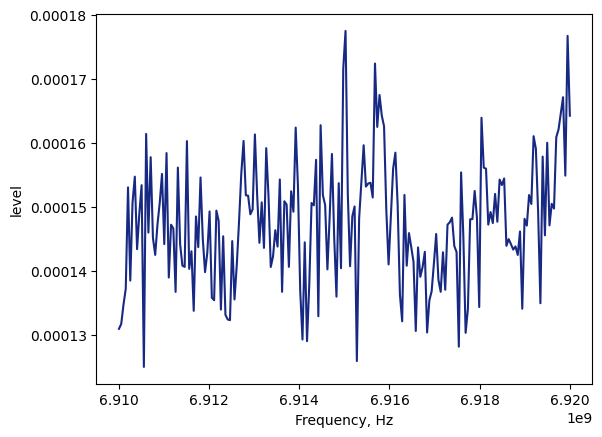

In [29]:
plot2d_abs(my_results, "ac_0")

# 3. Pulsed spectroscopy

In pulsed spectroscopy, the output is additionally modulated with an uploaded waveform. The waveform length is then limited to 16 or 32 us, depending on options installed. Pulsed spectroscopy also uses the internal hardware oscillator for modualtion of the waveform and demodulation of the acquired data.

## 3.1 Additional Experimental Parameters

Define the frequency scan, the number of averages and the readout pulse

In [ ]:
# increase number of averages, to compensate for shorter integration length of individual data points 
average_exponent=10

# define sweep parameter
start = 100e6
stop = 120e6
count = 21

sweep_parameter = LinearSweepParameter(uid="freq_sweep", start=start, stop=stop, count=count, axis_name="IF, Hz")

# readout pulse
measure_pulse = pulse_library.const(length=32.768e-6, amplitude=1.0) # max pulse length for spectroscopy

## 3.2 Define the Experiment

In [ ]:
exp = Experiment(uid="Resonator spectroscopy pulsed", 
    signals=[
        "measure", 
        "acquire"
    ]
)

# map experimental signals to logical signals
exp.map_signal("measure", q0["measure_line"])
exp.map_signal("acquire", q0["acquire_line"])

# set experiment calibration - frequency sweep of measure signal
exp.set_calibration(Calibration(
    {"measure": SignalCalibration(
            oscillator = Oscillator(
                frequency=sweep_parameter,
                modulation_type=ModulationType.HARDWARE,
            )
        )
    }
    )
)

# define the experimental sequence
## outer loop - near time frequency sweep
with exp.sweep(uid="sweep", parameter=sweep_parameter):
    # inner loop - real-time data acquisition in spectroscopy mode
    with exp.acquire_loop_rt(uid="shots", 
                            count=pow(2, average_exponent),
                            acquisition_type=AcquisitionType.SPECTROSCOPY
    ):
        # pulsed spectroscopy - play the measure pulse and start the data acquisition
        with exp.section(uid="spectroscopy"):
            exp.play(
                signal="measure",
                pulse=measure_pulse,
            )
            exp.acquire(signal="acquire", 
                handle="ac_0", 
                length=30e-6    # acquire results for 30us
            )
        # delay inserted to allow for signal processing, KNOWN ISSUE on SHFQA: needs to be very long
        with exp.section(uid="relax", length=50e-6):
            exp.reserve(signal="measure")

## 3.3 Connect to a Session and Run the Experiment

In [ ]:
session = Session(device_setup=device_setup)
session.connect(do_emulation=True)

my_results = session.run(exp)

## 3.4 Plot the results

In [ ]:
plot2d_abs(my_results, "ac_0")